In [1]:
import os
from glob import glob
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut

In [2]:
def compute_similarity(M):
    
    ntrial = M.shape[2]  # (ncell, ybin, ntrial)
    M_ = M.reshape((-1,ntrial)).T  # (ntrial, ncell*ybin)
    R = cosine_similarity(M_)  # Nonnegative affinity matrix (0 to 1)
        
    return R

def cluster_trials(R, context):
    '''
    Parameters
    ----------
    R : 2d array, shape (n_trials, n_trials)
        Similarity matrix used for clustering
    context : 1d array, shape (n_trials,)
        Context label for each trial

    Returns
    -------
    y : 1d array, shape (n_trials,)
        Cluster labels (majority class of familiar trials is labeled 0)
    '''
    # cluster = SpectralClustering(n_clusters=2, affinity='precomputed').fit(R)
    cluster = SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='cluster_qr').fit(R)
    y = cluster.labels_
    # l0 = stats.mode(y[np.where(context==0)[0]])[0].item()
    # if l0 == 0:
    if np.mean(y==context) > 0.5:
        return y
    else:
        return np.mod(y-1,2)
    
def decompose(X, y):
    
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    l2 = lambda u: np.sqrt(np.sum(u**2))
    weight = reg.coef_/l2(reg.coef_)
    
    return weight.ravel()

def decompose_trial(M, tuning_cluster):
    
    ntrial = M.shape[2]
    X = np.column_stack([F.ravel() for F in tuning_cluster])  # (N_pixels, 2)
    weights = np.zeros((ntrial,2))
    for r in range(ntrial):
        y = M[:,:,r].reshape((-1,1))
        weights[r] = decompose(X, y)
    
    return weights

def analyze_clusters(M, context, prct=100):
    
    ntrial = M.shape[2]
    R = compute_similarity(M)
    
    ## Discard disconnected trials
    R2 = np.copy(R)
    np.fill_diagonal(R2, np.NaN)
    # bad_trial = np.where(np.nanmean(R2, axis=1)==0)[0]  # Equivalent to prct=100
    bad_trial = np.where(np.nanpercentile(R2, prct, axis=1)==0)[0]
    if len(bad_trial) > 0:
        good_trial = np.setdiff1d(np.arange(ntrial), bad_trial)
        context = context[good_trial]
        R = R[good_trial][:,good_trial]
        M = np.delete(M, bad_trial, axis=2)
    else:
        good_trial = np.arange(ntrial)
    
    label = cluster_trials(R, context)
    a = np.logical_and(context==0, label==0)
    b = np.logical_and(context==1, label==1)
    correct_class = np.array([a.sum()/np.sum(context==0), b.sum()/np.sum(context==1)])
    print('Proportion of correct class in fam: %.4g' % correct_class[0])
    print('Proportion of correct class in nov: %.4g' % correct_class[1])
    
    # Tuning averaged within the given context and cluster
    tuning_cluster = [M[:,:,a].mean(axis=2), M[:,:,b].mean(axis=2)]
    
    return R, label, good_trial, tuning_cluster

In [135]:
# %% Setup
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}
p = 1
exps = ['Enriched','Dissimilar','Similar']
datapath = alldata[exps[p]][2]
day = [1,2,3]  # Recording days, None for all days
min_rate = 0/60  # Minimum transient rate for active cells
ybin = 20  # Number of spatial bins
ysigma = 0  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [136]:
# %% Load data
data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate, verbose=True)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent
    
print('Recording days:', days)
print('Context fam/nov:', ctx)

tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)
M = np.concatenate(tuning, axis=2)  # Combine categories (ncell, ybin, ntrial)
context = np.hstack([np.repeat(ctx[k], tuning[k].shape[2])
                     for k in range(len(tuning))])

------------------------------------
Total cells: 52
Active cells: 52
Proportion of active cells 100.00 %
Active in both 84.62 %
Active exclusively in Fam 1.92 %
Active exclusively in Nov 0.00 %
------------------------------------
Recording days: [1 1 1 1 2 2 2 2 3 3 3 3]
Context fam/nov: [0 1 0 1 0 1 0 1 0 1 0 1]


In [137]:
# %% Run for one mouse
R, label, good_trial, tuning_cluster = analyze_clusters(M, context, prct=90)
correct_class = np.sum(context[good_trial]==label)/len(label)
print('Proportion of correct class: %.4g' % correct_class)
weights = decompose_trial(M, tuning_cluster)

Proportion of correct class in fam: 0.8889
Proportion of correct class in nov: 0.8778
Proportion of correct class: 0.8833


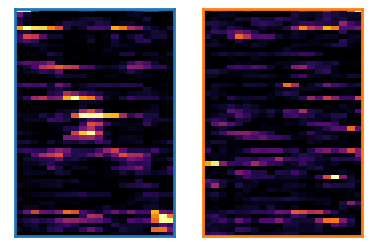

In [138]:
def show_cluster(tuning_cluster, colors=['C0','C1'], sort=0):
    
    N = len(tuning_cluster)
    order = ut.sort_tuning(tuning_cluster[sort])[1]
    rs = np.hstack([F.ravel() for F in tuning_cluster])
    vmax = np.percentile(rs, 99.5)
    
    fig, axs = plt.subplots(1,N,figsize=(4,2.8),sharex=True,sharey=True)
    for c, F in enumerate(tuning_cluster):
        axs[c].imshow(F[order], interpolation='none', cmap='inferno', vmin=0, vmax=vmax)
        axs[c].set(xticks=[], yticks=[], aspect='auto')
        for spine in axs[c].spines.values():
            spine.set(visible=True, edgecolor=colors[c], linewidth=2)
    
    return fig, axs
    
fig, axs = show_cluster(tuning_cluster, colors=['C0','C1'], sort=0)
fig.tight_layout()

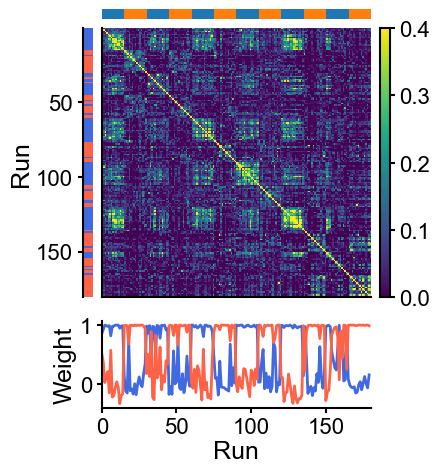

In [139]:
def plot_similarity(R, context, label, weights, figsize=(5,5)):
    
    ntrial = len(label)
    assert len(context)==ntrial, 'context has different length than label'
    assert len(R)==ntrial, 'similarity matrix has differnet size than label'
    
    fig, ax = plt.subplots(figsize=figsize)
    fig.subplots_adjust(left=0.22, right=0.78, bottom=0.34, top=0.9)
    ax_ctx = fig.add_axes([0.22, 0.92, 0.56, 0.02])  # Context (top)
    ax_lab = fig.add_axes([0.18, 0.34, 0.02, 0.56])  # Cluster label (left)
    cax = fig.add_axes([0.8, 0.34, 0.02, 0.56])  # Colorbar (right)
    ax2 = fig.add_axes([0.22, 0.11, 0.56, 0.18])  # Trial evolution (bottom)
    
    cmap_ctx = colors.ListedColormap(['C0','C1'])
    cmap_lab = colors.ListedColormap(['royalblue','tomato'])  # 'C2','C3'
    
    ax_ctx.axis('off')
    ax_ctx.imshow(context[np.newaxis,:], cmap=cmap_ctx)
    ax_ctx.set(aspect='auto')
    
    ax_lab.imshow(label[:,np.newaxis], cmap=cmap_lab, extent=[0,1,ntrial+0.5,0.5])
    ax_lab.get_xaxis().set_visible(False)
    ax_lab.spines['bottom'].set_visible(False)
    ax_lab.set(aspect='auto', ylabel='Run')
    
    rs = R[np.triu_indices(R.shape[0], k=1)]
    # vmax = np.percentile(rs,99)
    # vmax = np.ceil(np.max(rs)*10)/10
    vmax = np.ceil(np.percentile(rs,99)*10)/10
    
    img = ax.imshow(R, vmin=0, vmax=vmax, cmap='viridis', interpolation='none',
                    extent=[0.5,ntrial+0.5]*2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    fig.colorbar(img, cax=cax)
    
    ax2.plot(weights[:,0], c='royalblue', lw=2)
    ax2.plot(weights[:,1], c='tomato', lw=2)
    ax2.set(xlim=[0,ntrial], xlabel='Run', ylabel='Weight')
    
    return fig

fig = plot_similarity(R, context[good_trial], label, weights, figsize=(4.8,4.8))  # (3.6,3.6) or (4.8,4.8)
fig.savefig('Cross dissimilar3 day3.svg')